In [1]:
from google.colab import drive

# Monta o Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

def extract_subset_age_stratified(metadata_path, N=50, seed=42, age_bins=None):
    """
    Extrai um subset de pacientes estratificado por Glioma type + faixa etária,
    mantendo diversidade de Site, Sex, Manufacturer e Magnetic Field Strength.
    Considera apenas pacientes com dataset = train ou train-additional.

    Args:
        metadata_path (str): Caminho para o arquivo Excel com metadados.
        N (int): Número de pacientes do subset.
        seed (int): Seed para reprodutibilidade.
        age_bins (list ou int): Faixas de idade (bins) ou número de quantis (se int).

    Returns:
        pd.DataFrame: Subset selecionado.
    """
    np.random.seed(seed)

    # --- Lê o Excel ---
    df = pd.read_excel(metadata_path)

    # --- Filtra apenas dados de treino ---
    df = df[df['Train/Test/Validation '].isin(['Train', 'Train-additional'])].copy()
    print(f"✅ Filtrados {len(df)} registros com dataset = train/train-additional")

    # --- Extrai ID do paciente ---
    df['PatientID'] = df['BraTS Subject ID'].str.extract(r'(BraTS-GLI-\d+)')
    print(df['PatientID'].nunique())

    # --- Remove duplicados por paciente ---
    df_unique = df.drop_duplicates(subset='PatientID').copy()

    # --- Cria faixas de idade ---
    if isinstance(age_bins, int):
        df_unique['AgeGroup'] = pd.qcut(df_unique["Patient's Age"], q=age_bins, labels=False)
    elif isinstance(age_bins, list):
        df_unique['AgeGroup'] = pd.cut(df_unique["Patient's Age"], bins=age_bins, labels=False)
    else:
        df_unique['AgeGroup'] = pd.cut(df_unique["Patient's Age"],
                                       bins=[0,20,30,40,50,60,70,100],
                                       labels=False)

    # --- Ajusta N se necessário ---
    N = min(N, len(df_unique))

    selected_patients = []

    # --- Estratificação principal por Glioma type + AgeGroup ---
    df_unique['Strata'] = df_unique['Glioma type '].astype(str) + '-' + df_unique['AgeGroup'].astype(str)
    strata_counts = df_unique['Strata'].value_counts(normalize=True)

    for strata, prop in strata_counts.items():
        df_strata = df_unique[df_unique['Strata'] == strata]
        n_select = max(1, int(round(prop * N)))

        sampled = df_strata.sample(n=min(n_select, len(df_strata)), random_state=seed)
        selected_patients.append(sampled)

    # --- Concatena todos os estratos ---
    subset_df = pd.concat(selected_patients)

    # --- Ajusta exatamente N pacientes ---
    if len(subset_df) > N:
        subset_df = subset_df.sample(n=N, random_state=seed)
    elif len(subset_df) < N:
        remaining = df_unique[~df_unique['PatientID'].isin(subset_df['PatientID'])]
        subset_df = pd.concat([subset_df, remaining.sample(n=N-len(subset_df), random_state=seed)])

    return subset_df.reset_index(drop=True)

In [3]:
full_df = pd.read_excel(r'/content/drive/MyDrive/TCC/1.Data/BraTS-GLI/brats-ptg.xlsx')
age_bins = [0,20,30,40,50,60,70,100]  # ou use qcut
full_df['AgeGroup'] = pd.cut(full_df["Patient's Age"], bins=age_bins, labels=False)


In [4]:
n = 50
subset_df = extract_subset_age_stratified(r'/content/drive/MyDrive/TCC/1.Data/BraTS-GLI/brats-ptg.xlsx', N=n, seed=42, age_bins=None)
subset_df.to_excel(rf'/content/drive/MyDrive/TCC/test_subset_{n}.xlsx', index=False)
subset_df['AgeGroup'] = pd.cut(subset_df["Patient's Age"], bins=age_bins, labels=False)


✅ Filtrados 1621 registros com dataset = train/train-additional
731


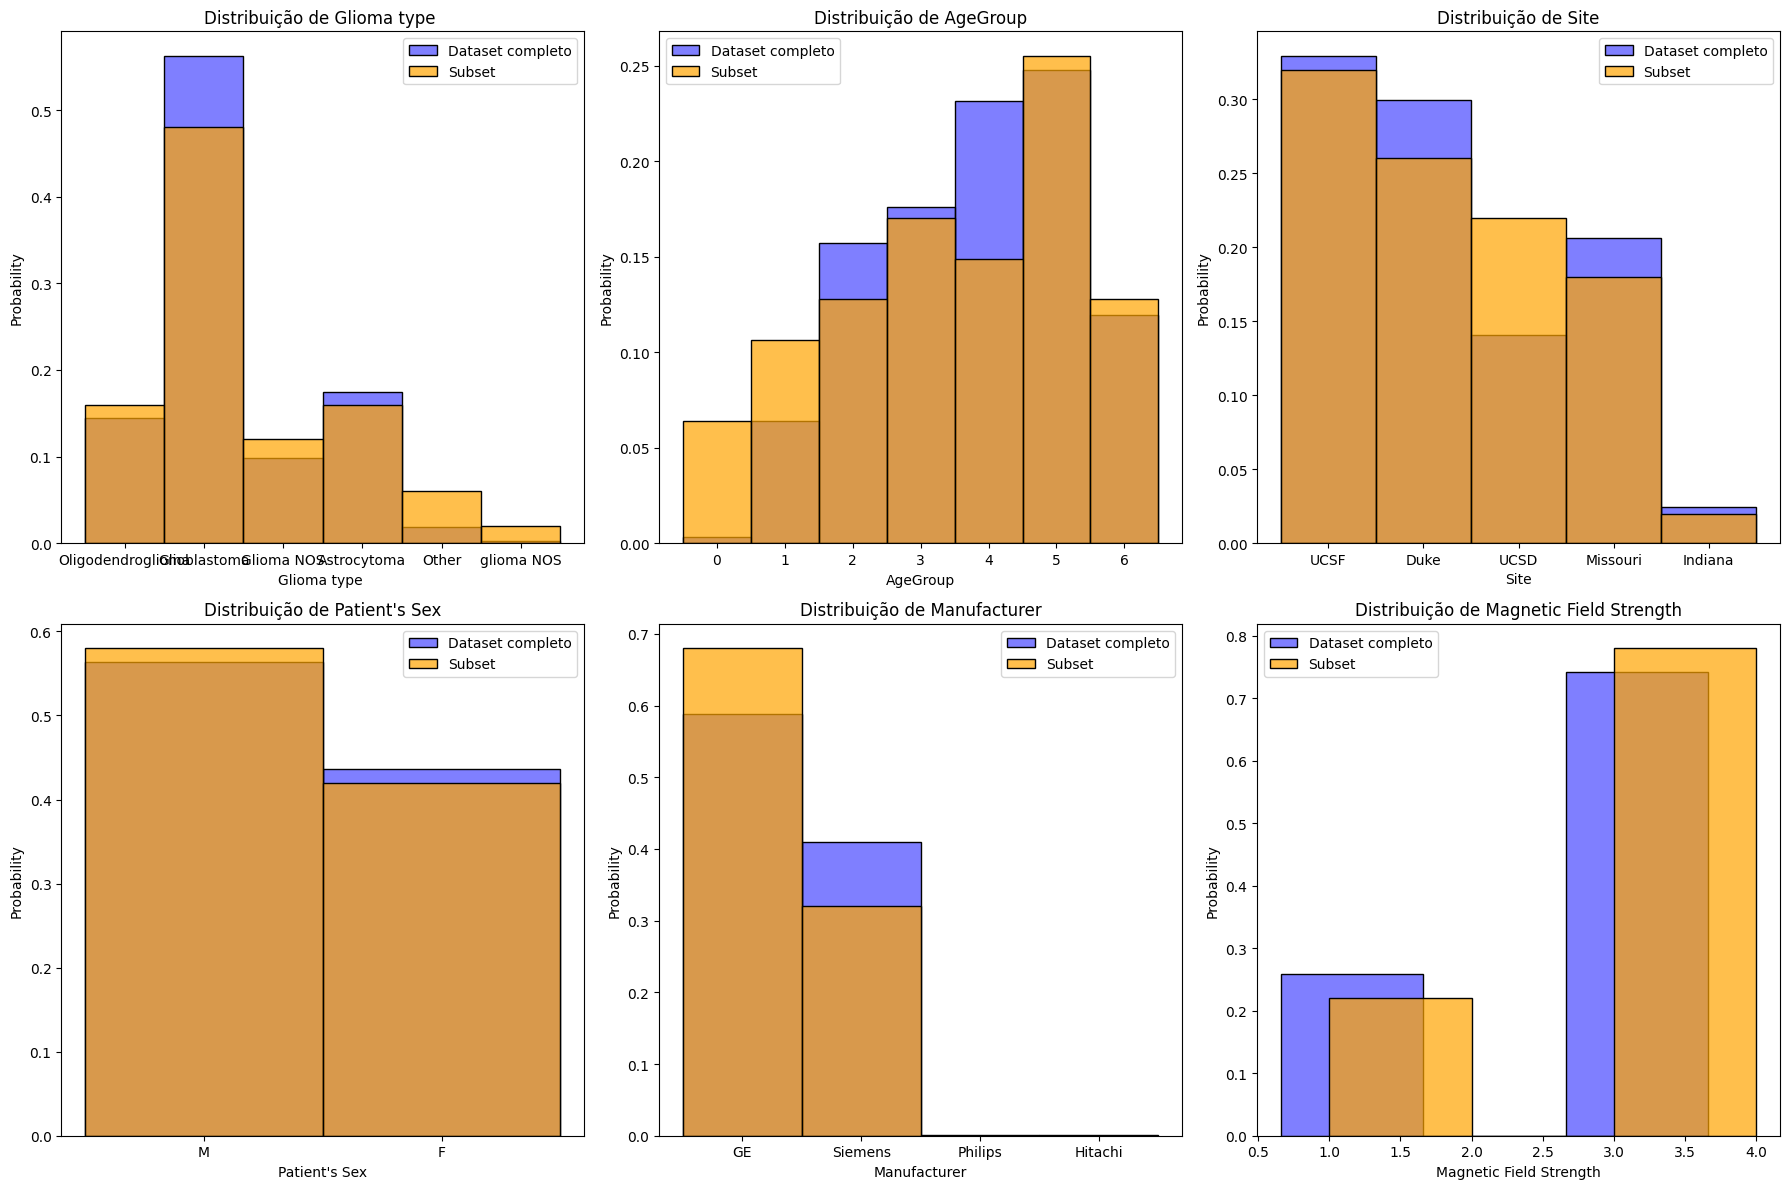

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comparison_histograms(full_df, subset_df):
    """
    Plota histogramas comparativos do dataset completo e do subset.
    """
    plt.figure(figsize=(18, 12))

    # Lista de colunas para comparar
    cols = ["Glioma type ", "AgeGroup", "Site", "Patient's Sex", 'Manufacturer', 'Magnetic Field Strength']

    for i, col in enumerate(cols, 1):
        plt.subplot(2, 3, i)
        sns.histplot(full_df[col], color='blue', label='Dataset completo', stat='probability', alpha=0.5, discrete=True)
        sns.histplot(subset_df[col], color='orange', label='Subset', stat='probability', alpha=0.7, discrete=True)
        plt.title(f'Distribuição de {col}')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Exemplo de uso:
plot_comparison_histograms(full_df, subset_df)


In [ ]:
full_df = pd.read_excel(r'/content/drive/MyDrive/TCC/1.Data/BraTS-GLI/brats-ptg.xlsx')
# Extrai ID do paciente
full_df['PatientID'] = full_df['BraTS Subject ID'].str.extract(r'(BraTS-GLI-\d+)')

# Remove duplicados por paciente
num_patients = full_df['PatientID'].nunique()
print(num_patients)

818


In [ ]:
import nibabel as nib

img = nib.load('/content/drive/MyDrive/TCC/1.Data/BraTS-GLI/brats2024-brats-gli-additionaltrainingdata/training_data_additional/BraTS-GLI-02405-100/BraTS-GLI-02405-100-seg.nii.gz')
data = img.get_fdata()
print(data.shape)

(182, 218, 182)


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
import subprocess
import re

# ------------------- CONFIG -------------------
BUCKET = "brats-final-training-818"
base_dir = f"gs://{BUCKET}/nnUNet_raw_database/Task001_MyBraTS"

labelsTr = f"{base_dir}/labelsTr"
labelsTs = f"{base_dir}/labelsTs"

# ------------------- FUNÇÃO -------------------
def rename_labels(gcs_folder):
    print(f"\n📁 Renomeando em: {gcs_folder}")

    # Lista arquivos
    result = subprocess.run(
        ["gsutil", "ls", f"{gcs_folder}/*.nii*"],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
    )

    files = [x for x in result.stdout.split("\n") if x.strip()]

    for full_path in files:
        fname = full_path.split("/")[-1]

        # novo nome removendo -seg
        new_name = re.sub(r"-seg", "", fname, flags=re.IGNORECASE)

        if new_name == fname:
            #print(f"  ➖ Sem alteração: {fname}")
            continue

        new_path = f"{gcs_folder}/{new_name}"

        print(f"  🔄 Renomeando: {fname} → {new_name}")
        subprocess.run(["gsutil", "mv", full_path, new_path])

# ------------------- EXECUTAR -------------------
rename_labels(labelsTr)
rename_labels(labelsTs)

print("\n✅ Renomeação concluída no bucket!")


📁 Renomeando em: gs://brats-final-training-818/nnUNet_raw_database/Task001_MyBraTS/labelsTr
  🔄 Renomeando: BraTS-GLI-00005-100-seg.nii.gz → BraTS-GLI-00005-100.nii.gz
  🔄 Renomeando: BraTS-GLI-00006-100-seg.nii.gz → BraTS-GLI-00006-100.nii.gz
  🔄 Renomeando: BraTS-GLI-00008-100-seg.nii.gz → BraTS-GLI-00008-100.nii.gz
  🔄 Renomeando: BraTS-GLI-00009-100-seg.nii.gz → BraTS-GLI-00009-100.nii.gz
  🔄 Renomeando: BraTS-GLI-00020-100-seg.nii.gz → BraTS-GLI-00020-100.nii.gz
  🔄 Renomeando: BraTS-GLI-00027-100-seg.nii.gz → BraTS-GLI-00027-100.nii.gz
  🔄 Renomeando: BraTS-GLI-00033-100-seg.nii.gz → BraTS-GLI-00033-100.nii.gz
  🔄 Renomeando: BraTS-GLI-00046-100-seg.nii.gz → BraTS-GLI-00046-100.nii.gz
  🔄 Renomeando: BraTS-GLI-00060-100-seg.nii.gz → BraTS-GLI-00060-100.nii.gz
  🔄 Renomeando: BraTS-GLI-00063-100-seg.nii.gz → BraTS-GLI-00063-100.nii.gz
  🔄 Renomeando: BraTS-GLI-00078-100-seg.nii.gz → BraTS-GLI-00078-100.nii.gz
  🔄 Renomeando: BraTS-GLI-00080-100-seg.nii.gz → BraTS-GLI-00080-100.ni

In [ ]:
# Caminho do arquivo que você enviou
ids_file = "/content/BraTS-GLI-02073-100.txt"

with open(ids_file) as f:
    IDS = [x.strip() for x in f.readlines() if x.strip()]

print("Total de IDs carregados:", len(IDS))
IDS[:10]  # visualizar os primeiros


Total de IDs carregados: 188


['BraTS-GLI-02073-100',
 'BraTS-GLI-02073-101',
 'BraTS-GLI-02095-100',
 'BraTS-GLI-02095-101',
 'BraTS-GLI-02095-102',
 'BraTS-GLI-02097-100',
 'BraTS-GLI-02097-101',
 'BraTS-GLI-02109-100',
 'BraTS-GLI-02109-101',
 'BraTS-GLI-02109-102']

In [ ]:
import subprocess

BUCKET = "brats-final-training-818"
gcs_imagesTr = f"gs://{BUCKET}/nnUNet_raw_database/Task001_MyBraTS/imagesTr"

print("🔍 PREVIEW — Listando arquivos que seriam apagados:\n")

for pid in IDS:
    prefix = f"{gcs_imagesTr}/{pid}"
    result = subprocess.run(
        ["gsutil", "ls", f"{prefix}*"],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
    )
    files = result.stdout.strip()
    if files:
        print(files + "\n")
    else:
        print(f"(nenhum arquivo encontrado para {pid})\n")

🔍 PREVIEW — Listando arquivos que seriam apagados:

gs://brats-final-training-818/nnUNet_raw_database/Task001_MyBraTS/imagesTr/BraTS-GLI-02073-100_0000.nii.gz
gs://brats-final-training-818/nnUNet_raw_database/Task001_MyBraTS/imagesTr/BraTS-GLI-02073-100_0001.nii.gz
gs://brats-final-training-818/nnUNet_raw_database/Task001_MyBraTS/imagesTr/BraTS-GLI-02073-100_0002.nii.gz
gs://brats-final-training-818/nnUNet_raw_database/Task001_MyBraTS/imagesTr/BraTS-GLI-02073-100_0003.nii.gz

(nenhum arquivo encontrado para BraTS-GLI-02073-101)

gs://brats-final-training-818/nnUNet_raw_database/Task001_MyBraTS/imagesTr/BraTS-GLI-02095-100_0000.nii.gz
gs://brats-final-training-818/nnUNet_raw_database/Task001_MyBraTS/imagesTr/BraTS-GLI-02095-100_0001.nii.gz
gs://brats-final-training-818/nnUNet_raw_database/Task001_MyBraTS/imagesTr/BraTS-GLI-02095-100_0002.nii.gz
gs://brats-final-training-818/nnUNet_raw_database/Task001_MyBraTS/imagesTr/BraTS-GLI-02095-100_0003.nii.gz

(nenhum arquivo encontrado para BraT

KeyboardInterrupt: 

In [ ]:
import subprocess
from pathlib import Path
import re

# -----------------------------
# 1) CARREGAR LISTA DE IDS
# -----------------------------
ids_file = "/content/BraTS-GLI-02073-100.txt"

with open(ids_file) as f:
    IDS = [x.strip() for x in f.readlines() if x.strip()]

print(f"IDs carregados: {len(IDS)}")


# -----------------------------
# 2) GERAR REGEX SEGURO
# -----------------------------
regex = "|".join(re.escape(x) for x in IDS)
pattern = re.compile(regex)

print("Regex gerado com segurança!")


# -----------------------------
# 3) LISTAR ARQUIVOS DO BUCKET
# -----------------------------
BUCKET = "brats-final-training-818"
gcs_imagesTr = f"gs://{BUCKET}/nnUNet_raw_database/Task001_MyBraTS/imagesTr"

# comando gsutil ls via Python
result = subprocess.run(
    ["gsutil", "ls", f"{gcs_imagesTr}/*.nii.gz"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)

files = [line.strip() for line in result.stdout.split("\n") if line.strip().startswith("gs://")]

print(f"Total de arquivos no bucket: {len(files)}")


# -----------------------------
# 4) FILTRAR SOMENTE OS IDs
# -----------------------------
to_delete = [f for f in files if pattern.search(f)]

print(f"Arquivos a deletar: {len(to_delete)}")
for f in to_delete[:20]:
    print(" -", f)
if len(to_delete) > 20:
    print("... (lista truncada)")


# -----------------------------
# 5) APAGAR (SEGURO)
# -----------------------------
if to_delete:
    print("\n🗑  Deletando arquivos...")
    subprocess.run(["gsutil", "-m", "rm"] + to_delete)
    print("✅ Remoção concluída!")
else:
    print("Nenhum arquivo corresponde aos IDs fornecidos.")

IDs carregados: 188
Regex gerado com segurança!
Total de arquivos no bucket: 3274
Arquivos a deletar: 340
 - gs://brats-final-training-818/nnUNet_raw_database/Task001_MyBraTS/imagesTr/BraTS-GLI-02073-100_0000.nii.gz
 - gs://brats-final-training-818/nnUNet_raw_database/Task001_MyBraTS/imagesTr/BraTS-GLI-02073-100_0001.nii.gz
 - gs://brats-final-training-818/nnUNet_raw_database/Task001_MyBraTS/imagesTr/BraTS-GLI-02073-100_0002.nii.gz
 - gs://brats-final-training-818/nnUNet_raw_database/Task001_MyBraTS/imagesTr/BraTS-GLI-02073-100_0003.nii.gz
 - gs://brats-final-training-818/nnUNet_raw_database/Task001_MyBraTS/imagesTr/BraTS-GLI-02095-100_0000.nii.gz
 - gs://brats-final-training-818/nnUNet_raw_database/Task001_MyBraTS/imagesTr/BraTS-GLI-02095-100_0001.nii.gz
 - gs://brats-final-training-818/nnUNet_raw_database/Task001_MyBraTS/imagesTr/BraTS-GLI-02095-100_0002.nii.gz
 - gs://brats-final-training-818/nnUNet_raw_database/Task001_MyBraTS/imagesTr/BraTS-GLI-02095-100_0003.nii.gz
 - gs://brats-

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
import subprocess
import re

BUCKET = "brats-final-training-818"
gcs_imagesTr = f"gs://{BUCKET}/nnUNet_raw_database/Task001_MyBraTS/imagesTr"

def gcs_ls(prefix):
    out = subprocess.run(
        ["gsutil", "ls", prefix],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
    ).stdout.strip().split("\n")
    return [x for x in out if x.strip()]


files = gcs_ls(f"{gcs_imagesTr}/*.nii.gz")

print("Arquivos encontrados:", len(files))

pattern_wrong = re.compile(r"^(brats-gli-\d+-\d+)-_0+(\d)\.nii\.gz$", re.IGNORECASE)

for full_path in files:
    filename = full_path.split("/")[-1]

    match = pattern_wrong.match(filename)
    if not match:
        continue

    patient_id = match.group(1)        # exemplo: brats-gli-02154-100
    modality_digit = match.group(2)    # exemplo: 2

    # Construir nome correto:
    new_filename = f"{patient_id}_000{modality_digit}.nii.gz"

    # Padronizar BraTS
    new_filename = new_filename.replace("brats-gli", "BraTS-GLI")

    new_path = f"{gcs_imagesTr}/{new_filename}"

    print(f"Renomeando: {filename} → {new_filename}")

    # copiar arquivo
    subprocess.run(["gsutil", "cp", full_path, new_path])
    # apagar original
    subprocess.run(["gsutil", "rm", full_path])

print("\n✅ Renomeação concluída!")


Arquivos encontrados: 2935
Renomeando: brats-gli-02155-100-_0001.nii.gz → BraTS-GLI-02155-100_0001.nii.gz
Renomeando: brats-gli-02155-100-_0002.nii.gz → BraTS-GLI-02155-100_0002.nii.gz
Renomeando: brats-gli-02155-100-_0003.nii.gz → BraTS-GLI-02155-100_0003.nii.gz
Renomeando: brats-gli-02156-100-_0000.nii.gz → BraTS-GLI-02156-100_0000.nii.gz
Renomeando: brats-gli-02156-100-_0001.nii.gz → BraTS-GLI-02156-100_0001.nii.gz
Renomeando: brats-gli-02156-100-_0002.nii.gz → BraTS-GLI-02156-100_0002.nii.gz
Renomeando: brats-gli-02156-100-_0003.nii.gz → BraTS-GLI-02156-100_0003.nii.gz
Renomeando: brats-gli-02157-100-_0000.nii.gz → BraTS-GLI-02157-100_0000.nii.gz
Renomeando: brats-gli-02157-100-_0001.nii.gz → BraTS-GLI-02157-100_0001.nii.gz
Renomeando: brats-gli-02157-100-_0002.nii.gz → BraTS-GLI-02157-100_0002.nii.gz
Renomeando: brats-gli-02157-100-_0003.nii.gz → BraTS-GLI-02157-100_0003.nii.gz
Renomeando: brats-gli-02158-100-_0000.nii.gz → BraTS-GLI-02158-100_0000.nii.gz
Renomeando: brats-gli-021

In [ ]:
import subprocess
import re

BUCKET = "brats-final-training-818"
gcs_imagesTr = f"gs://{BUCKET}/nnUNet_raw_database/Task001_MyBraTS/imagesTr"

# padrões corretos nnU-Net
correct_patterns = [
    "_0000",
    "_0001",
    "_0002",
    "_0003"
]

# padrões antigos/problema
bad_patterns = [
    "t1n",
    "t1c",
    "t2w",
    "t2f",
    "t1.",
    "t2.",
    "flair",
    "t1-",
    "t2-",
]

def gcs_ls(prefix):
    result = subprocess.run(
        ["gsutil", "ls", prefix],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    return [x for x in result.stdout.strip().split("\n") if x]


# ---------------------------- LISTAGEM ----------------------------

files = gcs_ls(f"{gcs_imagesTr}/*.nii.gz")
files = sorted(files, key=lambda x: x.lower())

print(f"Total de arquivos encontrados: {len(files)}")

incorrect = []
correct = []


# ------------------------- VERIFICAÇÃO ----------------------------

for full_path in files:
    filename = full_path.split("/")[-1].lower()

    # se contiver qualquer padrão antigo → errado
    if any(bad in filename for bad in bad_patterns):
        incorrect.append(full_path)
        continue

    # se contém sufixo correto → ok
    if any(good in filename for good in correct_patterns):
        correct.append(full_path)
        continue

    # se não caiu nos dois casos, é suspeito
    incorrect.append(full_path)


# ------------------------- RESULTADOS ----------------------------

print("\n============== RESULTADOS ==============")
print(f"✔ Arquivos corretos: {len(correct)}")
print(f"❌ Arquivos com nome errado: {len(incorrect)}\n")

if incorrect:
    print("❌ Arquivos com modalidades antigas (precisam renomear):\n")
    for f in incorrect:   # mostra só os primeiros 40 pra não explodir o Colab
        print(" -", f)
else:
    print("🎉 NÃO HÁ arquivos com nomes incorretos! Tudo no padrão 🎉")

Total de arquivos encontrados: 2924

============== RESULTADOS ==============
✔ Arquivos corretos: 2924
❌ Arquivos com nome errado: 0

🎉 NÃO HÁ arquivos com nomes incorretos! Tudo no padrão 🎉


In [ ]:
import subprocess
import re

BUCKET = "brats-final-training-818"
gcs_imagesTr = f"gs://{BUCKET}/nnUNet_raw_database/Dataset001_MyBraTS/imagesTr"
gcs_labelsTr = f"gs://{BUCKET}/nnUNet_raw_database/Dataset001_MyBraTS/labelsTr"


def gcs_ls(prefix):
    """Lista arquivos em um prefixo do GCS."""
    result = subprocess.run(
        ["gsutil", "ls", prefix],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    return [x.strip() for x in result.stdout.split("\n") if x.strip()]


# ----------------------------------------------------------
#  FUNÇÃO SOLICITADA → Extrai BraTS-GLI-xxxxx-yyy
# ----------------------------------------------------------
def extract_patient_id(filename):
    """
    Extrai o ID do paciente no formato BraTS-GLI-xxxxx-yyy
    de arquivos em imagesTr ou labelsTr.
    """
    filename = filename.split("/")[-1]  # pega só o nome
    m = re.match(r"(BraTS-GLI-\d{5}-\d{3})", filename, re.IGNORECASE)
    if m:
        return m.group(1)
    return None


# ---------------- LISTAR ARQUIVOS ----------------

images = gcs_ls(f"{gcs_imagesTr}/*.nii.gz")
labels = gcs_ls(f"{gcs_labelsTr}/*.nii.gz")

print(f"Imagens encontradas: {len(images)}")
print(f"Labels encontradas: {len(labels)}")

# ---------------- EXTRAIR IDs ----------------

image_cases = set(filter(None, (extract_patient_id(f) for f in images)))
label_cases  = set(filter(None, (extract_patient_id(f) for f in labels)))

# ---------------- DIFERENÇA ----------------

missing_labels = sorted(image_cases - label_cases)

print("\n❌ Casos em imagesTr SEM label correspondente:\n")
for c in missing_labels:
    print(" -", c)

print(f"\nTotal sem label: {len(missing_labels)}")

Imagens encontradas: 2933
Labels encontradas: 722

❌ Casos em imagesTr SEM label correspondente:

 - BraTS-GLI-02077-101
 - BraTS-GLI-02186-101
 - BraTS-GLI-02536-101
 - BraTS-GLI-02581-101
 - BraTS-GLI-02585-101
 - BraTS-GLI-02591-101
 - BraTS-GLI-02800-101
 - BraTS-GLI-02928-101
 - BraTS-GLI-03011-101

Total sem label: 9
